In [1]:
import random
import folium
import branca

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from cartopy.io import shapereader

pd.options.mode.chained_assignment = None 

In [2]:
df_cad = pd.read_csv("./data/BD_Linhas-de-Transmissão(Cadastro).csv", encoding='latin-1', sep=';')
df_camp = pd.read_csv("./data/BD_Linhas-de-Transmissão(Campos).csv", encoding='latin-1', sep=';')
df_docs = pd.read_csv("./data/BD_Linhas-de-Transmissão(Documentos de Medição).csv", encoding='latin-1', sep=';')

In [3]:
df_campos_medicao = df_camp[['Planilha Documentos de Medição', 'Unnamed: 4']]
new_header = df_campos_medicao.iloc[0]
df_campos_medicao = df_campos_medicao[1:]
df_campos_medicao.columns = new_header

df_campos_medicao

0            Coluna                                  Significado
1       Equipamento                      Identificador do objeto
2     Ponto medição            Identificador do ponto de medição
3       Doc.medição        Identificador do documento de medição
4              Data                       Data do ensaio/medição
5      Item medição  Posição da estrutura onde é feita a medição
6     Valor teórico                       Valor teórico esperado
7     LimInfIntMed.                     Limite inferior esperado
8     LimSupIntMed.                     Limite superior esperado
9   ValMed/PosTCont                                 Valor medido
10   Unid.caracter.                           Unidade de medição
11  Cód.valorização                        Catálogo de respostas
12  Txt.code codif.                                     Resposta
13      Denominação              Denominação do ponto de medição
14            Texto                                  Comentários

In [4]:
df_campos_cadastro = df_camp[['Planilha Cadastro', 'Unnamed: 1']]

new_header = df_campos_cadastro.iloc[0]
df_campos_cadastro = df_campos_cadastro[1:-5]
df_campos_cadastro.columns = new_header

df_campos_cadastro

0                Coluna                            Significado
1           Equipamento                Identificador do objeto
2  Linha de Transmissão  Identificador da linha de transmissão
3           Denominação                    Descrição do objeto
4       Dt.entr.serviço            Data de entrada em operação
5                Classe                    Tipo do equipamento
6            Código ABC                            Criticidade
7                Tensão            Nível de tensão de operação
8              Latitude                    Latitude geográfica
9             Longitude                   Longitude geográfica

In [5]:
df_cad.head()

Equipamento Linha de Transmissão Denominação Dt.entr.serviço  \
0       115280                 LT31   Torre 111             NaN   
1       115281                 LT31   Torre 112             NaN   
2       115282                 LT31   Torre 113             NaN   
3       115283                 LT31   Torre 114             NaN   
4       115284                 LT31   Torre 115             NaN   

             Classe Código ABC  Tensão     Latitude    Longitude  
0  L_TORRE_AUTOPORT          C     230  -22,9776099  -50,0565232  
1  L_TORRE_AUTOPORT          C     230  -22,9791718  -50,0531681  
2  L_TORRE_AUTOPORT          C     230  -22,9808738  -50,0494992  
3  L_TORRE_AUTOPORT          C     230  -22,9830172  -50,0449193  
4  L_TORRE_AUTOPORT          C     230  -22,9846747  -50,0413489

In [6]:
aux = df_cad[['Equipamento', 'Linha de Transmissão']]
df_docs = df_docs.merge(aux, on='Equipamento')

df_docs['Ano'] = df_docs['Data'].apply(lambda x: x.split("/")[-1])


In [7]:
df_qualif = df_docs[df_docs['Denominação'] == "Qualificacao do Equipamento"]
df_qualif.tail()

Equipamento  Ponto medição  Doc.medição        Data Item medição  \
344275       102929        4490236       594410  05/10/2018        TORRE   
344277       101848        4229236      7670932  10/12/2024        TORRE   
344278       101848        4229236      4549684  28/02/2023        TORRE   
344279       101848        4229236      1919434  02/06/2020        TORRE   
344284       101818        4479736       594158  05/10/2018        TORRE   

       Valor teórico LimInfIntMed. LimSupIntMed. ValMed/PosTCont  \
344275           NaN           NaN           NaN            9,00   
344277           NaN           NaN           NaN            5,00   
344278           NaN           NaN           NaN            4,00   
344279           NaN           NaN           NaN            5,00   
344284           NaN           NaN           NaN            9,00   

       Unid.caracter.  Cód.valorização Txt.code codif.  \
344275             UN              NaN             NaN   
344277             UN              NaN             NaN   
344278             UN              NaN             NaN   
344279             UN              NaN             NaN   
344284             UN              NaN             NaN   

                        Denominação                                     Texto  \
344275  Qualificacao do Equipamento                                       NaN   
344277  Qualificacao do Equipamento          D:0*1/ 0*2/ 0*3/ 0*4/ 3*5/ 164*9   
344278  Qualificacao do Equipamento  ROÇADA MANUAL. D:0*1/ 0*2/ 0*3/ 1*4/ 2*5   
344279  Qualificacao do Equipamento          D:0*1/ 0*2/ 0*3/ 0*4/ 2*5/ 165*9   
344284  Qualificacao do Equipamento                                       NaN   

       Linha de Transmissão   Ano  
344275               LT3235  2018  
344277               LT3235  2024  
344278               LT3235  2023  
344279               LT3235  2020  
344284               LT3235  2018

In [8]:
df_medicoes = df_docs[df_docs['Denominação'] != "Qualificacao do Equipamento"]
df_medicoes.tail()

Equipamento  Ponto medição  Doc.medição        Data   Item medição  \
344276       101848        4229113       793663  19/10/2018  CABO CONDUTOR   
344280       101848        6554301      7839101  10/01/2025            VÃO   
344281       101848        6554301      7668321  09/12/2024            VÃO   
344282       101848        6554301      4549065  23/02/2023            VÃO   
344283       101818        4479613       795613  19/10/2018  CABO CONDUTOR   

       Valor teórico LimInfIntMed. LimSupIntMed. ValMed/PosTCont  \
344276          0,00          0,00          6,00            1,00   
344280          0,00          0,00        100,00        6.000,00   
344281          0,00          0,00        100,00            0,00   
344282          0,00          0,00        100,00        6.600,00   
344283          0,00          0,00          6,00            1,00   

       Unid.caracter.  Cód.valorização  Txt.code codif.  \
344276             UN              8.0  CONDIÇÃO NORMAL   
344280             m2              1.0    INICIO DO VAO   
344281             m2              8.0  CONDIÇÃO NORMAL   
344282             m2              1.0    INICIO DO VAO   
344283             UN              8.0  CONDIÇÃO NORMAL   

                    Denominação Texto Linha de Transmissão   Ano  
344276  CABO CONDUTOR (DIR/UNI)     5               LT3235  2018  
344280            ROCADA MANUAL     4               LT3235  2025  
344281            ROCADA MANUAL     5               LT3235  2024  
344282            ROCADA MANUAL     4               LT3235  2023  
344283  CABO CONDUTOR (DIR/UNI)     5               LT3235  2018

# Analise Exploratoria

In [9]:
df_cad['Latitude'] = df_cad['Latitude'].apply(lambda x: x.replace(',', '.'))
df_cad['Longitude'] = df_cad['Longitude'].apply(lambda x: x.replace(',', '.'))

df_cad['Latitude'] = pd.to_numeric(df_cad['Latitude'], errors='coerce')
df_cad['Longitude'] = pd.to_numeric(df_cad['Longitude'], errors='coerce')

In [10]:
from branca.element import Figure
fig = Figure(width=600, height=400)

df = df_cad[~df_cad['Latitude'].isna()]

grupos = df.groupby('Linha de Transmissão')

colors = {}

m = folium.Map(location=([-23.533773, -46.625290]))
# folium.TileLayer('cartodbdark_matter').add_to(m)

for nome_linha, grupo in list(grupos)[:80]:
    grupo = grupo.reset_index(drop=True)

    if nome_linha not in colors:
        colors[nome_linha] =  f"#{random.randint(0, 0xFFFFFF):06x}"
    
    for idx in range(1, len(grupo)):

        origin = grupo.loc[idx-1, :]
        destination = grupo.loc[idx, :]

        folium.CircleMarker([origin['Latitude'], origin['Longitude']],
                        radius=2, color=colors[nome_linha],
                        fill_color=colors[nome_linha], # divvy color
                       ).add_to(m)

    folium.CircleMarker([destination['Latitude'], destination['Longitude']],
                        radius=2, color=colors[nome_linha],
                        fill_color=colors[nome_linha], # divvy color
                    ).add_to(m)

fig.add_child(m)

In [11]:
denominacao_map = {
    "CORRO.": "CORROSÃO",
    "CORROSAO": "CORROSÃO",
    "CORROS": "CORROSÃO",
    "ISOL": "ISOL",
    "ESPACADOR": "ESPAÇADOR",
    "RABICHO": "RABICHO",
    "PECAS": "PEÇAS",
    "PECA": "PEÇAS",
    "ROCADA": "ROÇADA",
    "PARA-RAIO": "PARA-RAIO",
    "FERRAGENS": "FERRAGENS",
    "FERRAG": "FERRAGENS",
    "CABO CONDUTOR": "CABO CONDUTOR",
    "ESFERA": "ESFERA",
    "TENTO ROMPIDO": "TENTO ROMPIDO",
    "TENTO": "TENTO ROMPIDO",
    "AMORTECEDOR CONDUTOR": "AMORTECEDOR CONDUTOR",
    "JUMPER": "JUMPER",
    "EMENDA": "EMENDA",
    "TEMP": "TEMP",
    "GRAMPO DE SUSPENSAO CONDUTOR": "GRAMPO DE SUSPENSAO CONDUTOR",
    "BOBINA DE BLOQUEIO": "BOBINA DE BLOQUEIO",
    "CARGA RUPTURA": "CARGA RUPTURA",
    "GRAMPO DE ANCORAGEM CONDUTOR": "GRAMPO DE ANCORAGEM CONDUTOR",
    "PROTEÇÃO": "PROTEÇÃO (CHIFRE / ANEL)",
}

def process_denominacao(x):
    for key in denominacao_map:
        if key in x:
            return denominacao_map[key].upper()
    return x.upper()

df_medicoes['denominação_processed'] = df_medicoes['Denominação'].apply(lambda x: process_denominacao(x))

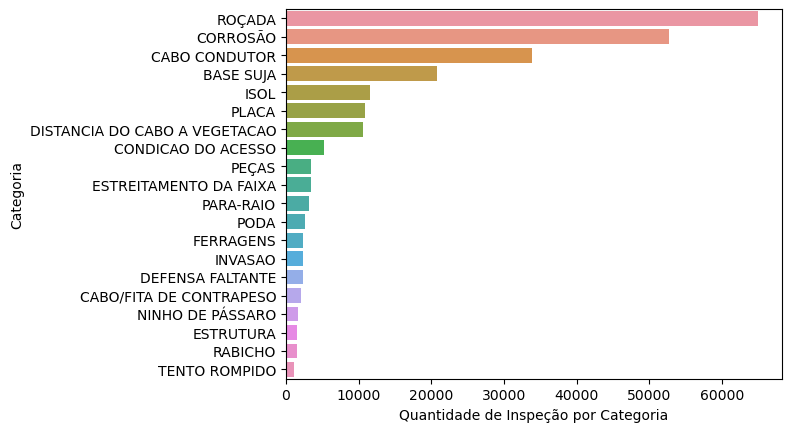

In [12]:
aux_data = df_medicoes['denominação_processed'].value_counts()[:20]

plt.title("")

sns.barplot(
    y=aux_data.index,
    x=aux_data.values, orient='h'
)

plt.xlabel("Quantidade de Inspeção por Categoria")
plt.ylabel("Categoria")
plt.show()

In [13]:
def convert_str_to_number(x):
    if isinstance(x, str):
        return float(x.replace('.', '').replace(',', '.'))
    return x
    

df_medicoes['ValMed/PosTCont'] = df_medicoes['ValMed/PosTCont'].apply(lambda x: convert_str_to_number(x))
df_medicoes['LimInfIntMed.'] = df_medicoes['LimInfIntMed.'].apply(lambda x: convert_str_to_number(x))
df_medicoes['LimSupIntMed.'] = df_medicoes['LimSupIntMed.'].apply(lambda x: convert_str_to_number(x))


df_medicoes['inside_limit'] = (df_medicoes['ValMed/PosTCont'] >= df_medicoes['LimInfIntMed.']) & (df_medicoes['ValMed/PosTCont'] <= df_medicoes['LimSupIntMed.'])
df_medicoes['deviation'] = df_medicoes['ValMed/PosTCont'] - ((df_medicoes['LimInfIntMed.'] + df_medicoes['LimSupIntMed.'])/2)

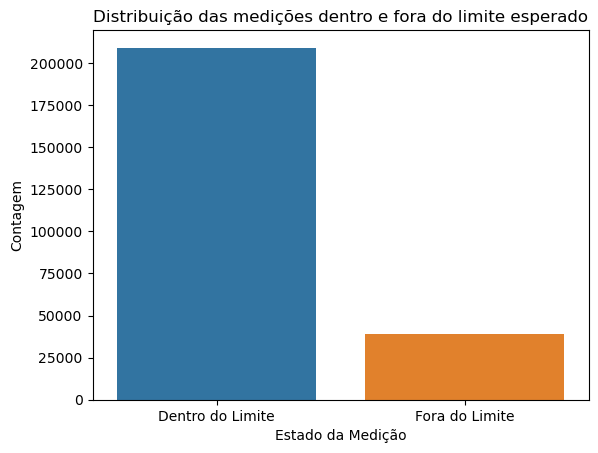

In [14]:
aux_counts = df_medicoes['inside_limit'].value_counts()
replace_ = {True: 'Dentro do Limite', False: 'Fora do Limite'}

sns.barplot(
    x=[replace_[i] for i in aux_counts.index],
    y=aux_counts.values
)
plt.ylabel("Contagem")
plt.xlabel("Estado da Medição")
plt.title("Distribuição das medições dentro e fora do limite esperado")
plt.show()

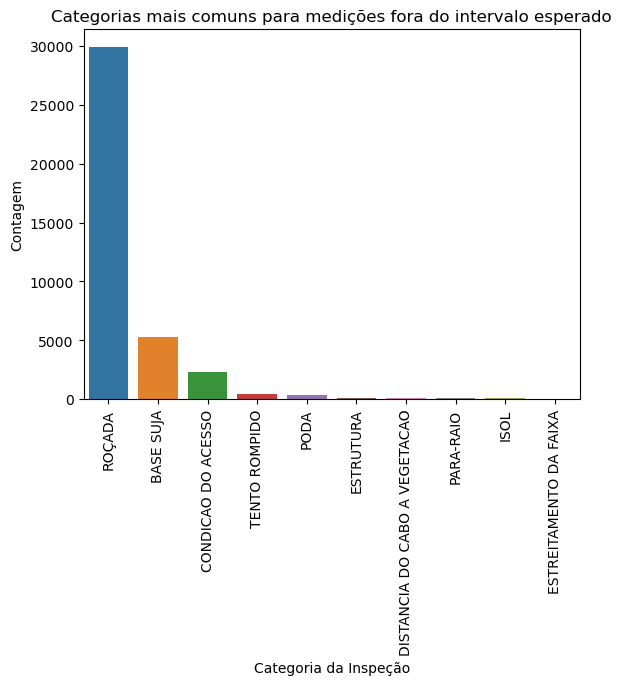

In [15]:
out_limit  = df_medicoes[df_medicoes['inside_limit'] == False]

counts_aux = out_limit['denominação_processed'].value_counts()

sns.barplot(
    x=counts_aux.index[:10],
    y=counts_aux.values[:10]
)
plt.xticks(rotation=90)
plt.ylabel("Contagem")
plt.xlabel("Categoria da Inspeção")
plt.title("Categorias mais comuns para medições fora do intervalo esperado")
plt.show()

In [22]:
aux_df_docs = df_medicoes[df_medicoes['denominação_processed'] != 'QUALIFICACAO DO EQUIPAMENTO']
# aux_df_docs  = aux_df_docs[aux_df_docs['inside_limit'] == False]


inspecoes_motivo = aux_df_docs.groupby('Equipamento', as_index = False)['denominação_processed'].agg(pd.Series.mode)
inspecoes = aux_df_docs.groupby('Equipamento', as_index = False)['denominação_processed'].count()
anos = aux_df_docs.groupby('Equipamento', as_index = False)['Ano'].nunique()

# df_cad.merge()
inspecoes = inspecoes.merge(anos, on='Equipamento')
inspecoes['Taxa'] = inspecoes["denominação_processed"]/inspecoes['Ano']

inspecoes['count_Denominação'] = inspecoes['denominação_processed']
del inspecoes['denominação_processed']

aux_cad = df_cad.merge(inspecoes, on='Equipamento')
aux_cad = aux_cad.merge(inspecoes_motivo, on='Equipamento')


aux_cad['above_threshold'] = aux_cad['Taxa'] > 6

fig = Figure(width=1200, height=1000)

df = aux_cad[~aux_cad['Latitude'].isna()]
df = df[df['above_threshold'] == True]

grupos = df.groupby('Linha de Transmissão')

colors = {
}

m = folium.Map(location=([-23.533773, -46.625290]))
folium.TileLayer('Cartodb Positron').add_to(m)

for nome_linha, grupo in list(grupos)[:]:
    grupo = grupo.reset_index(drop=True)


    for idx in range(0, len(grupo)):

        origin = grupo.loc[idx, :]

        if isinstance(origin['denominação_processed'], str):
            if origin['denominação_processed'] not in colors:
                colors[origin['denominação_processed']] =  f"#{random.randint(0, 0xFFFFFF):06x}"

            folium.CircleMarker([origin['Latitude'], origin['Longitude']],
                radius=3, color=colors[origin['denominação_processed']],
                fill_color=colors[origin['denominação_processed']],
                popup=origin['denominação_processed'], fill=True
            ).add_to(m)
        
        else:
            if origin['denominação_processed'][-1] not in colors:
                colors[origin['denominação_processed'][-1]] =  f"#{random.randint(0, 0xFFFFFF):06x}"

            folium.CircleMarker([origin['Latitude'], origin['Longitude']],
                radius=3, color=colors[origin['denominação_processed'][-1]],
                fill_color=colors[origin['denominação_processed'][-1]],
                popup=origin['denominação_processed'], fill=True
            ).add_to(m)

       

legends = [f'&nbsp; <i class="fa fa-circle" style="color:{colors[i]}"></i> {i} &nbsp; <br>' for i in sorted(colors)[:21]]

legend_html = '''
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 300px; height: 350px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;">
     &nbsp; <b>Legend</b> <br>'''+" ".join(legends)+'''     
</div>
{% endmacro %}
'''

legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)


fig.add_child(m)
fig.add_child(legend)


m

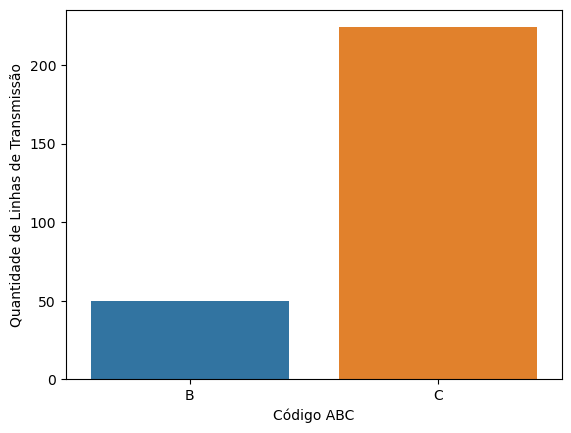

In [23]:
aux_data = df_cad.groupby('Código ABC')['Linha de Transmissão'].nunique()

sns.barplot(
    x=aux_data.index,
    y=aux_data.values
)
plt.ylabel("Quantidade de Linhas de Transmissão")
plt.show()

Text(0, 0.5, 'Proporção')

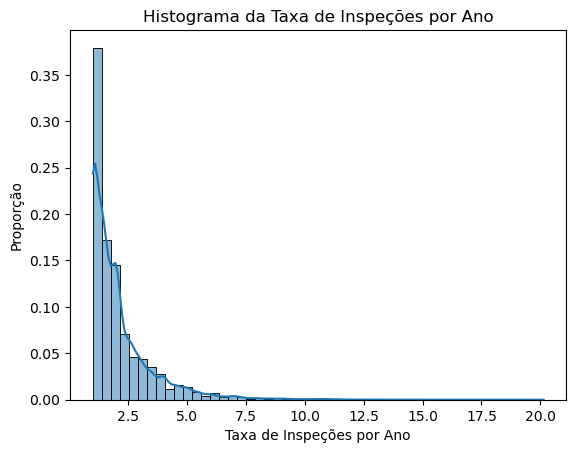

In [24]:
sns.histplot(
    x=inspecoes['Taxa'],
    stat="probability", common_norm=False,  bins=50, kde=True
)

plt.title("Histograma da Taxa de Inspeções por Ano")
plt.xlabel("Taxa de Inspeções por Ano")
plt.ylabel("Proporção")

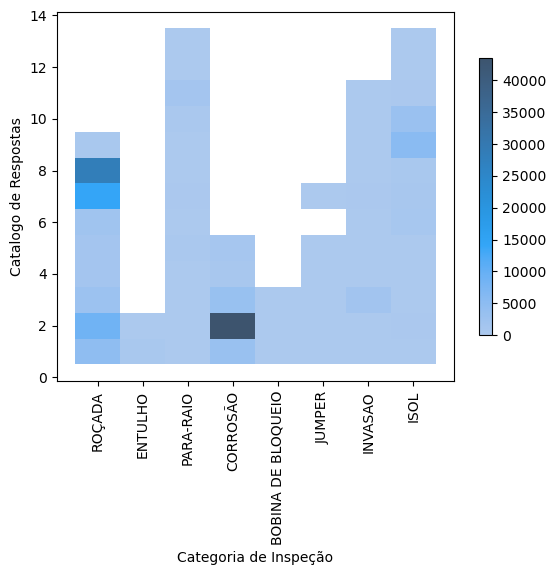

In [27]:
aux_df = df_medicoes[df_medicoes['denominação_processed'].isin(['ROÇADA', 'CORROSÃO', 'ENTULHO', 'ISOL', 'JUMPER', 'PARA-RAIO', 'INVASAO', 'BOBINA DE BLOQUEIO'])]

sns.histplot(
    x=aux_df['denominação_processed'],
    y=aux_df['Cód.valorização'], discrete=(True, True),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.xticks(rotation=90)
plt.xlabel("Categoria de Inspeção")
plt.ylabel("Catalogo de Respostas")
plt.show()

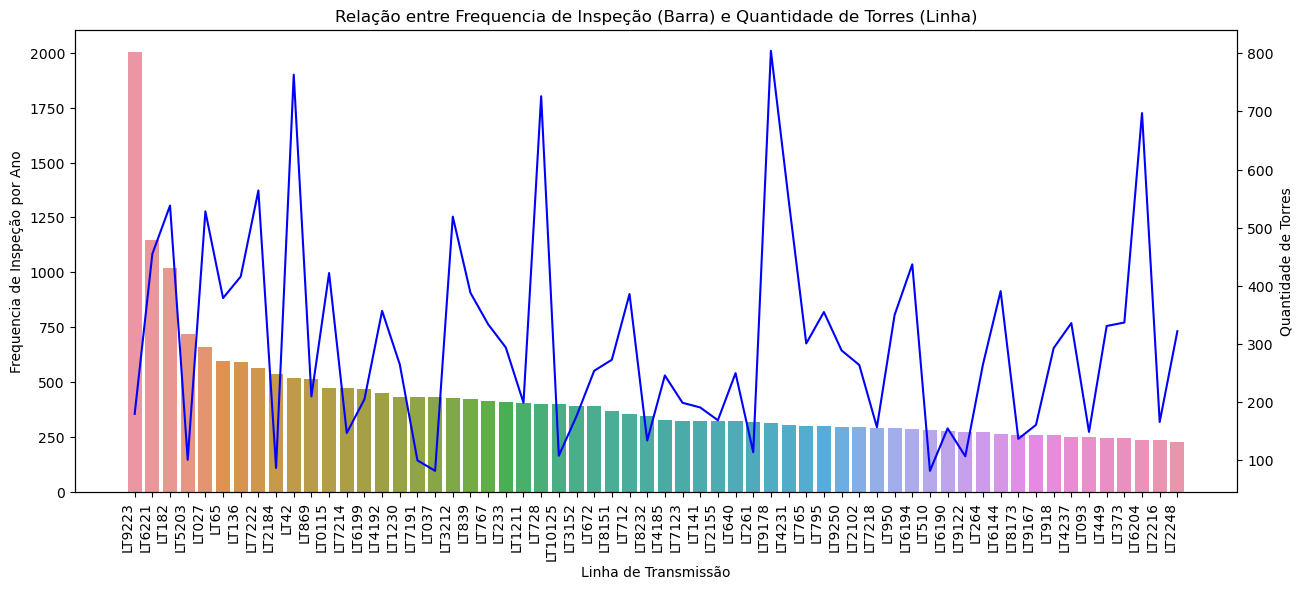

In [ ]:

aux_data = (df_docs.groupby('Linha de Transmissão')['Denominação'].count()/df_docs.groupby('Linha de Transmissão')['Ano'].nunique()).sort_values(ascending=False)[:60]

aux_cad = df_cad[df_cad['Linha de Transmissão'].isin(aux_data.index)]
aux_cad = aux_cad.groupby('Linha de Transmissão')['Equipamento'].nunique()

plt.figure(figsize=(15, 6))

sns.barplot(
    x=aux_data.index,
    y=aux_data.values
)

plt.title("Relação entre Frequencia de Inspeção (Barra) e Quantidade de Torres (Linha)")

plt.ylabel("Frequencia de Inspeção por Ano")
plt.xticks(rotation=90, ha='right')

ax2 = plt.twinx()
sns.lineplot(x=aux_cad.index, y=aux_cad.values, color="b", ax=ax2, markers='x')
plt.ylabel("Quantidade de Torres")


plt.show()


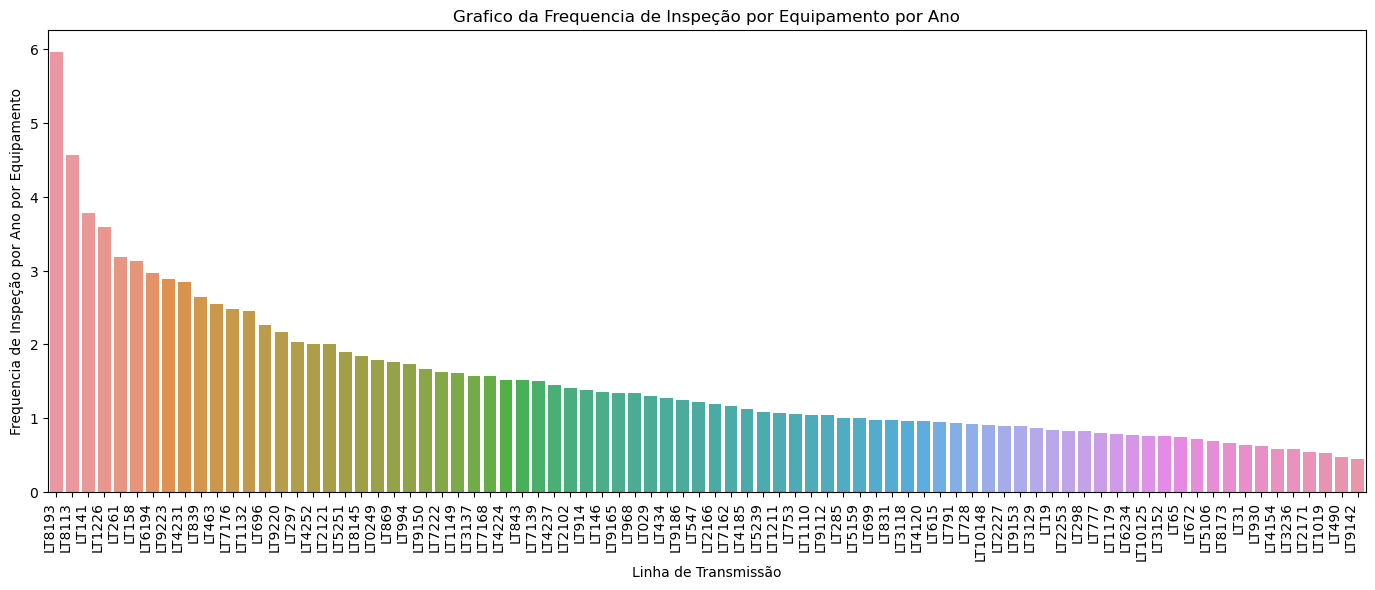

In [ ]:

aux_data = (df_docs.groupby('Linha de Transmissão')['Denominação'].count()/df_docs.groupby('Linha de Transmissão')['Ano'].nunique()/df_docs.groupby('Linha de Transmissão')['Equipamento'].nunique()).sort_values(ascending=False)[::3]

plt.figure(figsize=(17, 6))

sns.barplot(
    x=aux_data.index,
    y=aux_data.values
)

plt.title("Grafico da Frequencia de Inspeção por Equipamento por Ano")

plt.ylabel("Frequencia de Inspeção por Ano por Equipamento")
plt.xticks(rotation=90, ha='right')


plt.show()
